## **8 Ensemble Methods**



### **Introduction**


I am going explore two ensemble methods:

  - AdaBoost, and
  - Random Forests

And make a recommendation for a bank about which model they should use in production for better fraud detection.

### **Dataset**
  
The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 237 frauds out of 142,167 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions.

It contains only numerical input variables which are the result of a [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount in Euros. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
# These are the libraries you will use for this assignment, you may not import anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

# This is the credit card data provided, we'll use sklearn
# methods to do cross validation to estimate error
df_cc = pd.read_csv('cc.csv', error_bad_lines=False)

<ipython-input-46-dca1f411c0cc>:13: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_cc = pd.read_csv('cc.csv', error_bad_lines=False)
Skipping line 5750: expected 31 fields, saw 51
Skipping line 9582: expected 31 fields, saw 40
Skipping line 15331: expected 31 fields, saw 53
Skipping line 19163: expected 31 fields, saw 41
Skipping line 21079: expected 31 fields, saw 33
Skipping line 26830: expected 31 fields, saw 41
Skipping line 32578: expected 31 fields, saw 34

Skipping line 34493: expected 31 fields, saw 42
Skipping line 40241: expected 31 fields, saw 36
Skipping line 44073: expected 31 fields, saw 37
Skipping line 51739: expected 31 fields, saw 41
Skipping line 55572: expected 31 fields, saw 35
Skipping line 59405: expected 31 fields, saw 35
Skipping line 61320: expected 31 fields, saw 34
Skipping line 63236: expected 31 fields, saw 39
Skipping line 65152: expected 31 fields, saw 34

Sk

## **Q1 Partition the data for cross validation**



Load the data, and split the data set into $X$ (the feature dataframe, `df_X`) and $y$ (the target series `s_y`). Define our partitions.  

We know this is a _super_ skewed data set, so we worry about our target class being underrepresented in a random k-fold selection. With this in mind, we use a [stratifed k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), since it will preserve our class balance in our experiements. Use $k=3$, . Instantiate an instance of the `StratifiedKFold` class, and use the generator `split` to populate the test and train dictonaries:
   - `d_train_df_X` : key is the fold number, value is the attribute training dataframe at that fold
   - `d_test_df_X`  : key is the fold number, value is the attribute test dataframe at that fold
   - `d_train_s_y`  : key is the fold number, value is the target training series at that fold
   - `d_train_s_y`  : key is the fold number, value is the target test series at that fold

In [ ]:
df_cc.dropna(inplace=True)
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)


d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()

# Write your code here
for i, (train_index, test_index) in enumerate(skf.split(df_X, s_y)):
    d_train_df_X[i] = df_X.iloc[train_index]
    d_test_df_X[i] = df_X.iloc[test_index]
    d_train_s_y[i] = s_y.iloc[train_index]
    d_test_s_y[i] = s_y.iloc[test_index]

In [ ]:
# Observe the test data and verify that the target training is as equally distributed as possible
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())

0.0    53115
1.0       89
Name: Class, dtype: int64
0.0    53115
1.0       88
Name: Class, dtype: int64
0.0    53115
1.0       88
Name: Class, dtype: int64


## **Q2 Implementing AdaBoost Classifier**

As we learned in class, AdaBoost is a boosting ensemble method that starts with a weak classifier and iteratively adds to it by focusing on the misclassified instances. In many AdaBoost implementations, "Decision Stumps" (decision trees with a single split) are used as the base classifier.

While AdaBoost can work with various base classifiers, the default in `Scikit-learn`'s implementation is `DecisionTreeClassifier(max_depth=1)`, which is essentially a decision stump (a weak classifier).

In this question, you will implement a function called `train_and_plot_adaboost()` that will do the following:

* Model training and prediction: Instantiate the AdaBoost classifier with the specified parameters: `AdaBoostClassifier(n_estimators=25, random_state=23)`

* `fit` to train the model.For predictions, you can use `predict` method for class predictions or `predict_proba` method to get the probability of being in class 0 or class 1. You will do cross-validation by loop over the 𝑘 folds using the dictionaries from the first problem. For each fold, calculate the following metrics:
    * Accuracy
    * True Positive Rate (TPR)
    * Positive Predictive Value (PPV)
    * False Positive Rate (FPR)
    * ROC Curve Plotting:

* Plot the ROC curve for each fold. You may use the roc_curve, RocCurveDisplay, from Scikit-learn. There is a great example in the documentation on plotting ROC curves in cross validation that is helpful.


* After looping through all the folds, save the predictions from the 3rd fold into a variable named `y_hat_ab`. This is the variable your function will return.


AdaBoost focuses on instances that were misclassified in previous iterations, which can lead to improved performance. Depending on the data size and the number of estimators, AdaBoost can take some time to run. Please be patient and allow it a few minutes if needed.


In [ ]:
def train_and_plot_adaboost():
    '''
    Trains a Random Forest classs.sifier on the provided training data and plots the ROC curve
    for each fold in the cross-validation process
    '''
    import numpy as np

    k = 3
    acc_ab = np.zeros(k)
    tpr_ab = np.zeros(k)
    ppv_ab = np.zeros(k)
    fpr_ab = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()
    y_hat_rf = None

    # Complete this function
    for key in d_train_df_X.keys():
        print("Working on {}".format(key))


        # Train AdaBoost classifier
        ada = AdaBoostClassifier(n_estimators=25, random_state=23)
        ada.fit(d_train_df_X[key], d_train_s_y[key])

        # Predict the decision function scores
        y_score = ada.decision_function(d_test_df_X[key])

        # Compute the ROC values
        fpr, tpr, _ = roc_curve(d_test_s_y[key], y_score)

        # Compute the AUC (Area Under the Curve)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve using RocCurveDisplay
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC Curve')
        roc_display.plot(ax=ax)

        # Accuracy
        y_pred = ada.predict(d_test_df_X[key])
        acc_ab[fold_count] = np.mean(y_pred == d_test_s_y[key])

        # True positive rate
        tpr_ab[fold_count] = tpr[1]

        # False positive rate
        fpr_ab[fold_count] = fpr[1]

        # Positive Predictive Value
        ppv_ab[fold_count] = np.sum((y_pred == 1) & (d_test_s_y[key] == 1)) / np.sum(y_pred == 1)

        # Store predictions from the 3rd fold
        if key == 2:
            y_hat_ab = y_pred

        fold_count += 1


    print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
    print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
    print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))


    # plot the ROC Curve

    plt.show()

    return y_hat_rf


    y_hat_ab = train_and_plot_adaboost()


### **Q3 Implementing The Random Forest Classifier and Testing Its Performance**

Random Forest is an ensemble method that constructs a multitude of decision trees during training. For predictions, the mode of the classes (classification) of individual trees is used. The trees are built completely with no pruning. Hence, every leaf in the tree will be pure, but individual trees might be overfitted to the training set.

In this question, you will implement a function called `train_and_plot_randomforest()` where you will implement the following:

* While building the decision trees, at every internal node, randomly select 𝑝 attributes. Identify the best split that minimizes impurity among these 𝑝 attributes. The parameter 𝑝 corresponds to the `max_features` parameter in the `Scikit-learn`'s Random Forest Classifier.

**Model Training**
* Instantiate the Random Forest classifier with the specified parameters:
`RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)`. `fit` to train the model. For predictions, you can use `predict` method for class predictions. `predict_proba` method to get the probability of being in class 0 or class 1. These probabilities are used when creating ROC curves.

**Cross Validation**

* Loop over the 𝑘 folds using the dictionaries from the first problem.
For each fold, calculate the following metrics:
* Accuracy
* True Positive Rate (TPR)
* Positive Predictive Value (PPV)
* False Positive Rate (FPR)

**ROC Curve Plotting**

* Using the probabilities obtained from `predict_proba`, compute the ROC values.
* Plot the ROC curve for each fold. You can utilize the `RocCurveDisplay` from `Scikit-learn`.
* Refer to the Scikit-learn documentation for an example on plotting ROC curves in cross-validation.

**Saving Predictions**

* After looping through all the folds, save the predictions from the 3rd fold into a variable named `y_hat_rf`. This is what your function will return.



Working on 0
Working on 1
Working on 2
The min, mean, and max TPR are: 0.02, 0.04, and 0.06
The min, mean, and max PPV are: 0.93, 0.95, and 0.97
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


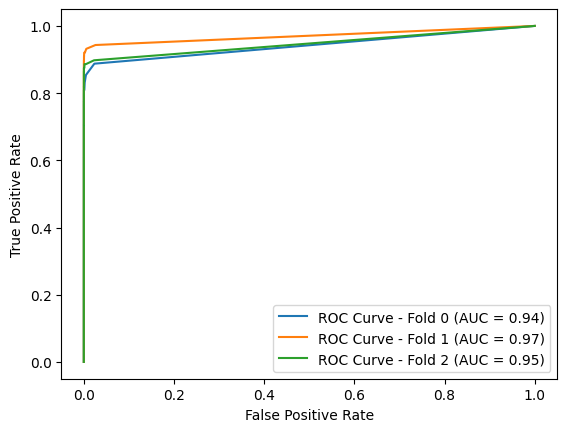

In [ ]:
def train_and_plot_randomforest():
    '''
    Trains a Random Forest classifier on the provided training data and plots the ROC curve
    for each fold in the cross-validation process.
    '''

    k = 3
    acc_rf = np.zeros(k)
    tpr_rf = np.zeros(k)
    ppv_rf = np.zeros(k)
    fpr_rf = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()
    y_hat_rf = None

    for key in d_train_df_X.keys():
        print("Working on {}".format(key))

        # Train RandomForest classifier
        rf = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)
        rf.fit(d_train_df_X[key], d_train_s_y[key])

        # Get the probability scores for the positive class
        y_score = rf.predict_proba(d_test_df_X[key])[:, 1]

        # Compute the ROC values
        fpr, tpr, _ = roc_curve(d_test_s_y[key], y_score)

        # Compute the AUC (Area Under the Curve)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve using RocCurveDisplay
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'ROC Curve - Fold {fold_count}')
        roc_display.plot(ax=ax)

        # Accuracy
        y_pred = rf.predict(d_test_df_X[key])
        acc_rf[fold_count] = np.mean(y_pred == d_test_s_y[key])

        # True positive rate
        tpr_rf[fold_count] = tpr[1]

        # False positive rate
        fpr_rf[fold_count] = fpr[1]

        # Positive Predictive Value
        ppv_rf[fold_count] = np.sum((y_pred == 1) & (d_test_s_y[key] == 1)) / (np.sum(y_pred == 1) + np.finfo(float).eps)

        # Store predictions from the 3rd fold
        if key == 2:
            y_hat_rf = y_pred

        fold_count += 1

    print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
    print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
    print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

    # plot the ROC curve
    plt.show()

    return y_hat_rf

y_hat_rf = train_and_plot_randomforest()

### **Q4 Calculate the Cost of Fraud**

In the above problems, we saved the predictions of the 3rd fold into the variables `y_hat_ab` and `y_hat_rf` for the AdaBoost and RandomForest models respectively.

Now, the Bank wants you to tell them how much money they are going to save if they deploy either of these fraud algorithms to the real-time payment processing system.  Assume that there is not a currently deployed fraud detection algorithm.  

For every fraudulent transaction that is not predicted as fraudulent the bank looses twice that much money.  So, a fradulent charge for €10 is undectected, it costs the bank €20.  Also, if a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction.

Using the 3rd fold test sample, calculate how much money the Bank will save with each algorithm, and make a recommendation of which algorithm to deploy to production. All amounts are given in Euros.

In [ ]:
# First, calculate the current cost to the bank with no fraud decection
cost_ab_undetected_fraud = fold_3_amount[(y_hat_ab != 1) & (d_test_s_y[2] == 1)].sum() * 2.0
cost_ab_false_fraud = fold_3_amount[(y_hat_ab == 1) & (d_test_s_y[2] != 1)].count() * 3.0
print("The bank will save €{:.2f} by deploying the AdaBoost algorithm".format(current_cost - cost_ab_undetected_fraud - cost_ab_false_fraud))


The current cost to the bank is €19120.26


In [ ]:
# your code here
cost_rf_undetected_fraud = fold_3_amount[(y_hat_rf != 1) & (d_test_s_y[2] == 1)].sum() * 2.0
cost_rf_false_fraud = fold_3_amount[(y_hat_rf == 1) & (d_test_s_y[2] != 1)].count() * 3.0
print("The bank will save €{:.2f} by deploying the Random Forest algorithm".format(current_cost - cost_rf_undetected_fraud - cost_rf_false_fraud))

The bank will save €13159.86 by deploying the Random Forest algorithm


In [ ]:
# your code here
cost_rf_undetected_fraud = (d_test_s_y[2] != y_hat_rf).sum() * 2 * d_test_df_X[2].loc[d_test_s_y[2] == 1, 'Amount'].sum()
cost_rf_false_fraud = (y_hat_rf != d_test_s_y[2]).sum() * 3

print("The bank will save €{:.2f} by deploying the Random Forest algorithm".format(current_cost - cost_rf_undetected_fraud - cost_rf_false_fraud))


The bank will save €-325098.42 by deploying the Random Forest algorithm
